#### scVI model benchmarking using scIB of healthy PBMC data


**Objective**: Build and run different scVI models for healthy PBMC data from _Cai et al 2020_ and _Yoshida et al 2021_ and asssess manifolds with scIB

**Developed by**: Mairi McClean

**Affiliation**: Institute of Computational Biology, Helmholtz Munich

-v230628

### Load modules and set figure params

In [2]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde
from scvi_colab import install


Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

### Read in data for integration

- _Cai et al 2020_

In [4]:
caiy2020 = sc.read_h5ad('/Users/mairi.mcclean/example_data_lake/processed_files/final_qc_mm230627/human/cai_2020/CaiY2020_PBMC_mm230627.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

In [5]:
caiy2020.obs['status'].value_counts()

active_TB    33104
Healthy      22049
latent_TB    17993
Name: status, dtype: int64

In [ ]:
caiy_healthy = caiy2020[caiy2020.obs['status'].isin(['Healthy'])]
caiy_healthy

In [ ]:
caiy_healthy.obs['status'].value_counts()

- _Yoshida et al 2021_

In [ ]:
yoshida2021 = sc.read_h5ad('/Users/mairi.mcclean/example_data_lake/processed_files/final_qc_mm230627/human/yoshida_2021/Yoshida2021_PBMC_mm230628.h5ad')
yoshida2021

In [ ]:
yoshida_healthy = yoshida2021[yoshida2021.obs['COVID_status'].isin(['Healthy'])]
yoshida_healthy

In [ ]:
caiy_healthy.obs['COVID_status'].value_counts()

- Concatenate objects

In [ ]:
adata = caiy_healthy.concatenate(yoshida_healthy, batch_key = 'dataset', batch_categories = ['caiy2020', 'yoshida2021'], join = 'inner')
adata

### Calculate HVGs

In [22]:
adata = caiy_healthy.copy()
adata.layers['counts'] = adata.X.copy()

In [23]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


#### Remove unrequired variables prior to model run

In [24]:
del caiy2020
del yoshida2021


### Integration with scVI


#### Model 1

In [25]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [26]:
vae_1 = scvi.model.SCVI(adata, n_layers=2, n_latent=15, gene_likelihood="nb", dispersion="gene-batch")

In [27]:
scvi.model.SCVI.view_anndata_setup(vae_1)

Anndata setup with scvi-tools version 0.20.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 22049 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 3000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     H2     │          0          │
│                    │     H1     │          1          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [28]:
vae_1.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 363/363: 100%|██████████| 363/363 [37:13<00:00,  5.83s/it, loss=1.71e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=363` reached.


Epoch 363/363: 100%|██████████| 363/363 [37:13<00:00,  6.15s/it, loss=1.71e+03, v_num=1]


In [29]:
adata.obsm["X_scVI_1"] = vae_1.get_latent_representation()

In [30]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scVI_1")
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata, min_dist=0.5, spread=8, random_state=0)

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [31]:
plt.figure(figsize = (5, 5))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

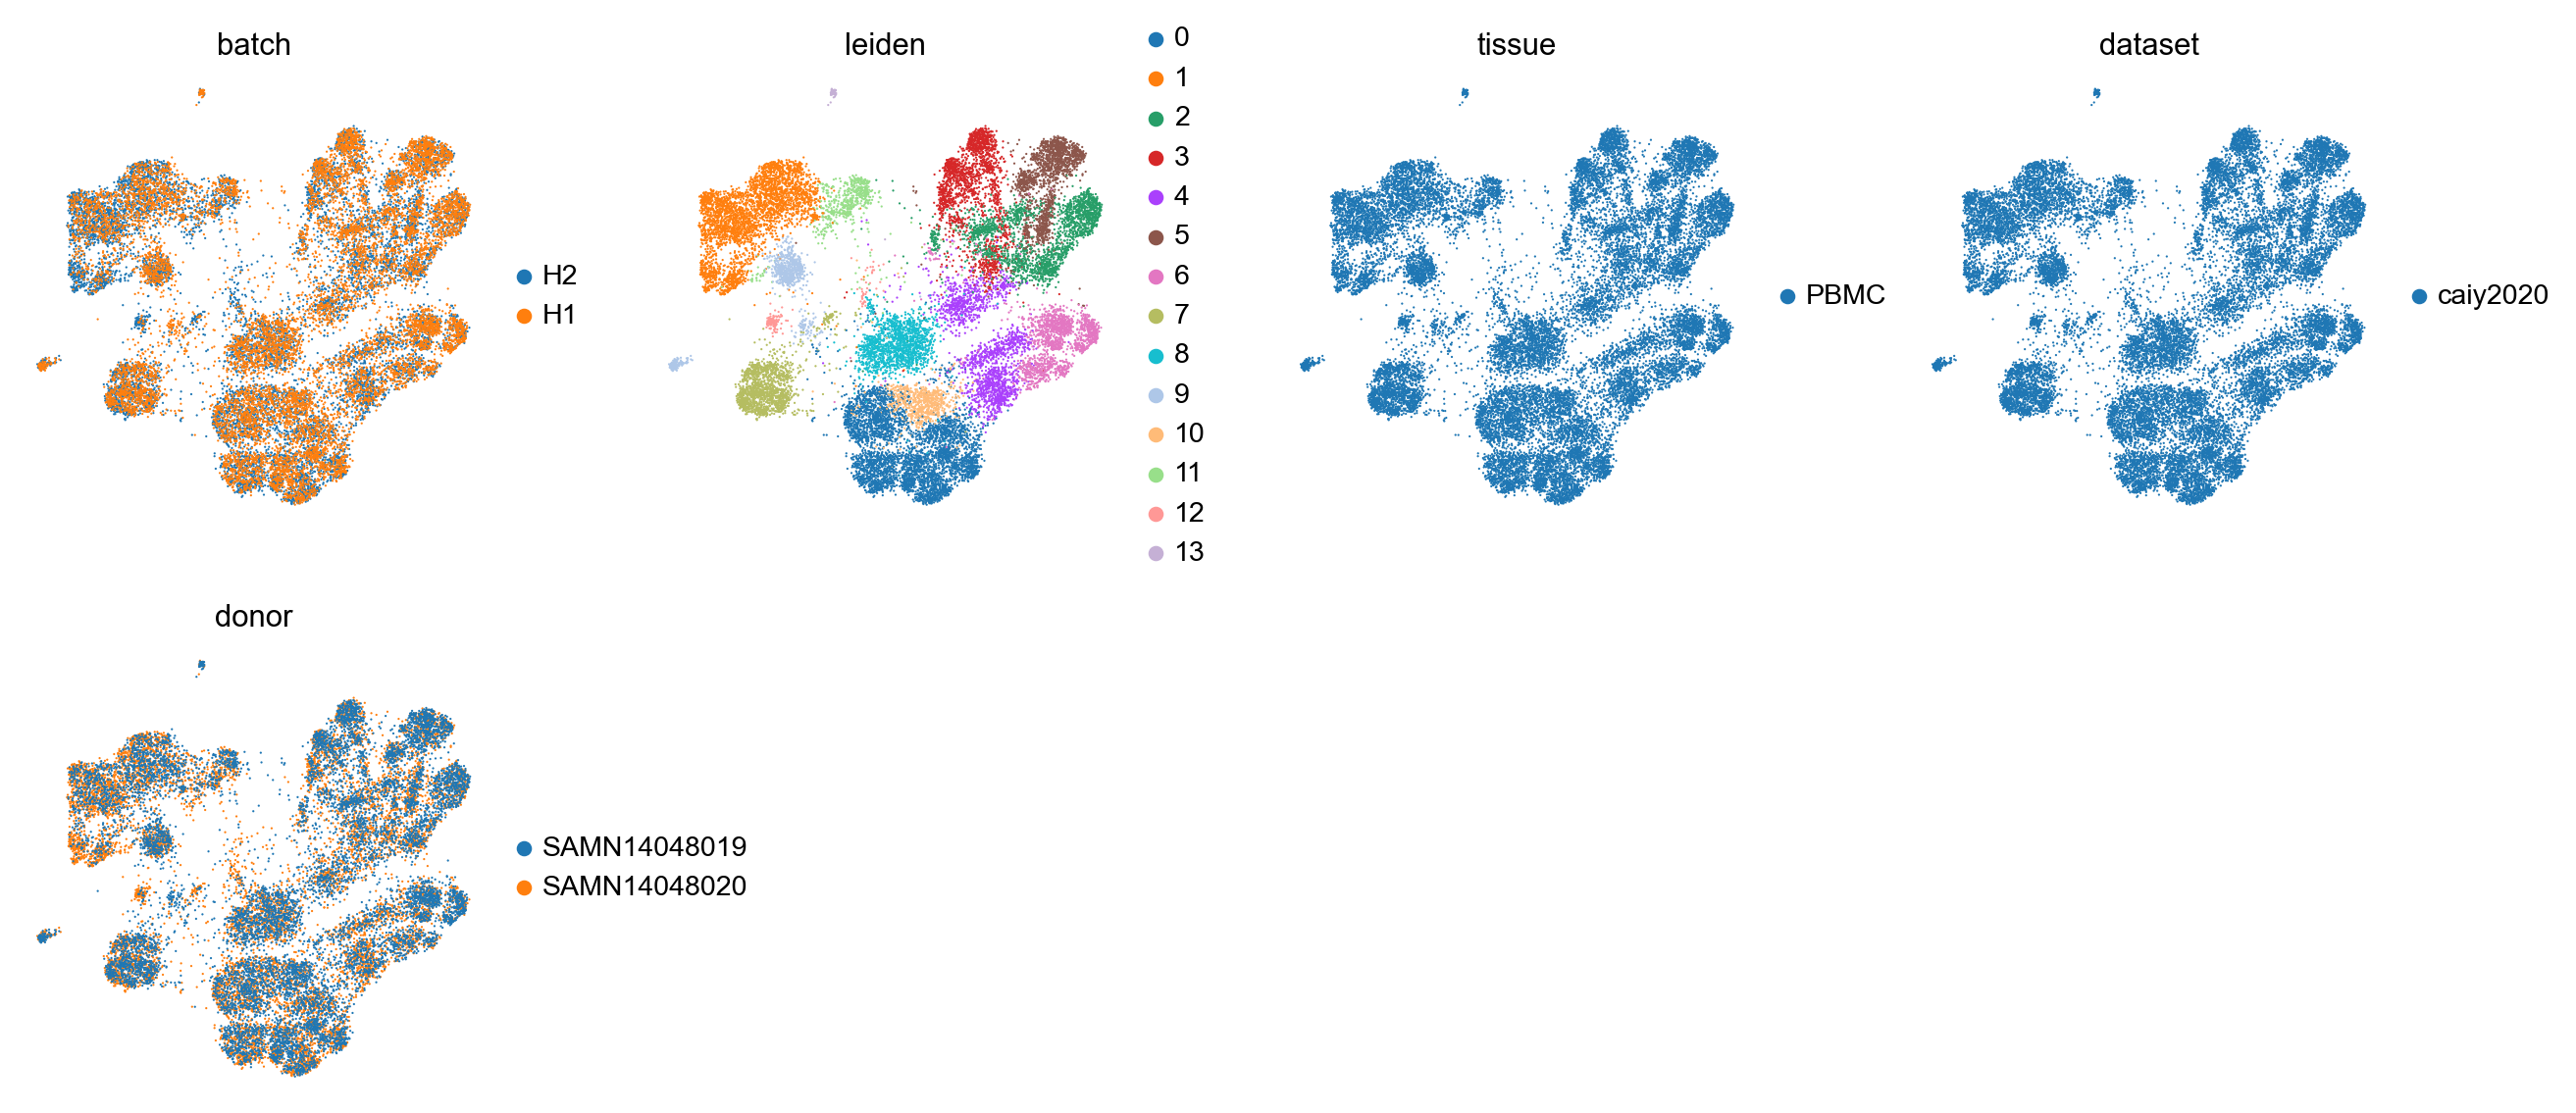

In [32]:
sc.pl.umap(
    adata,
    color=["batch", "leiden", "tissue", "dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


#### Model 2

In [33]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [34]:
vae_2 = scvi.model.SCVI(adata, n_layers=3, n_latent=25, gene_likelihood="nb", dispersion="gene-batch")

In [35]:
scvi.model.SCVI.view_anndata_setup(vae_2)

Anndata setup with scvi-tools version 0.20.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 22049 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 3000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     H2     │          0          │
│                    │     H1     │          1          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [36]:
vae_2.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 363/363: 100%|██████████| 363/363 [40:35<00:00,  6.57s/it, loss=1.72e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=363` reached.


Epoch 363/363: 100%|██████████| 363/363 [40:35<00:00,  6.71s/it, loss=1.72e+03, v_num=1]


In [37]:
adata.obsm["X_scVI_2"] = vae_2.get_latent_representation()

In [38]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scVI_2")
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata, min_dist=0.5, spread=8, random_state=0)

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [39]:
plt.figure(figsize = (5, 5))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

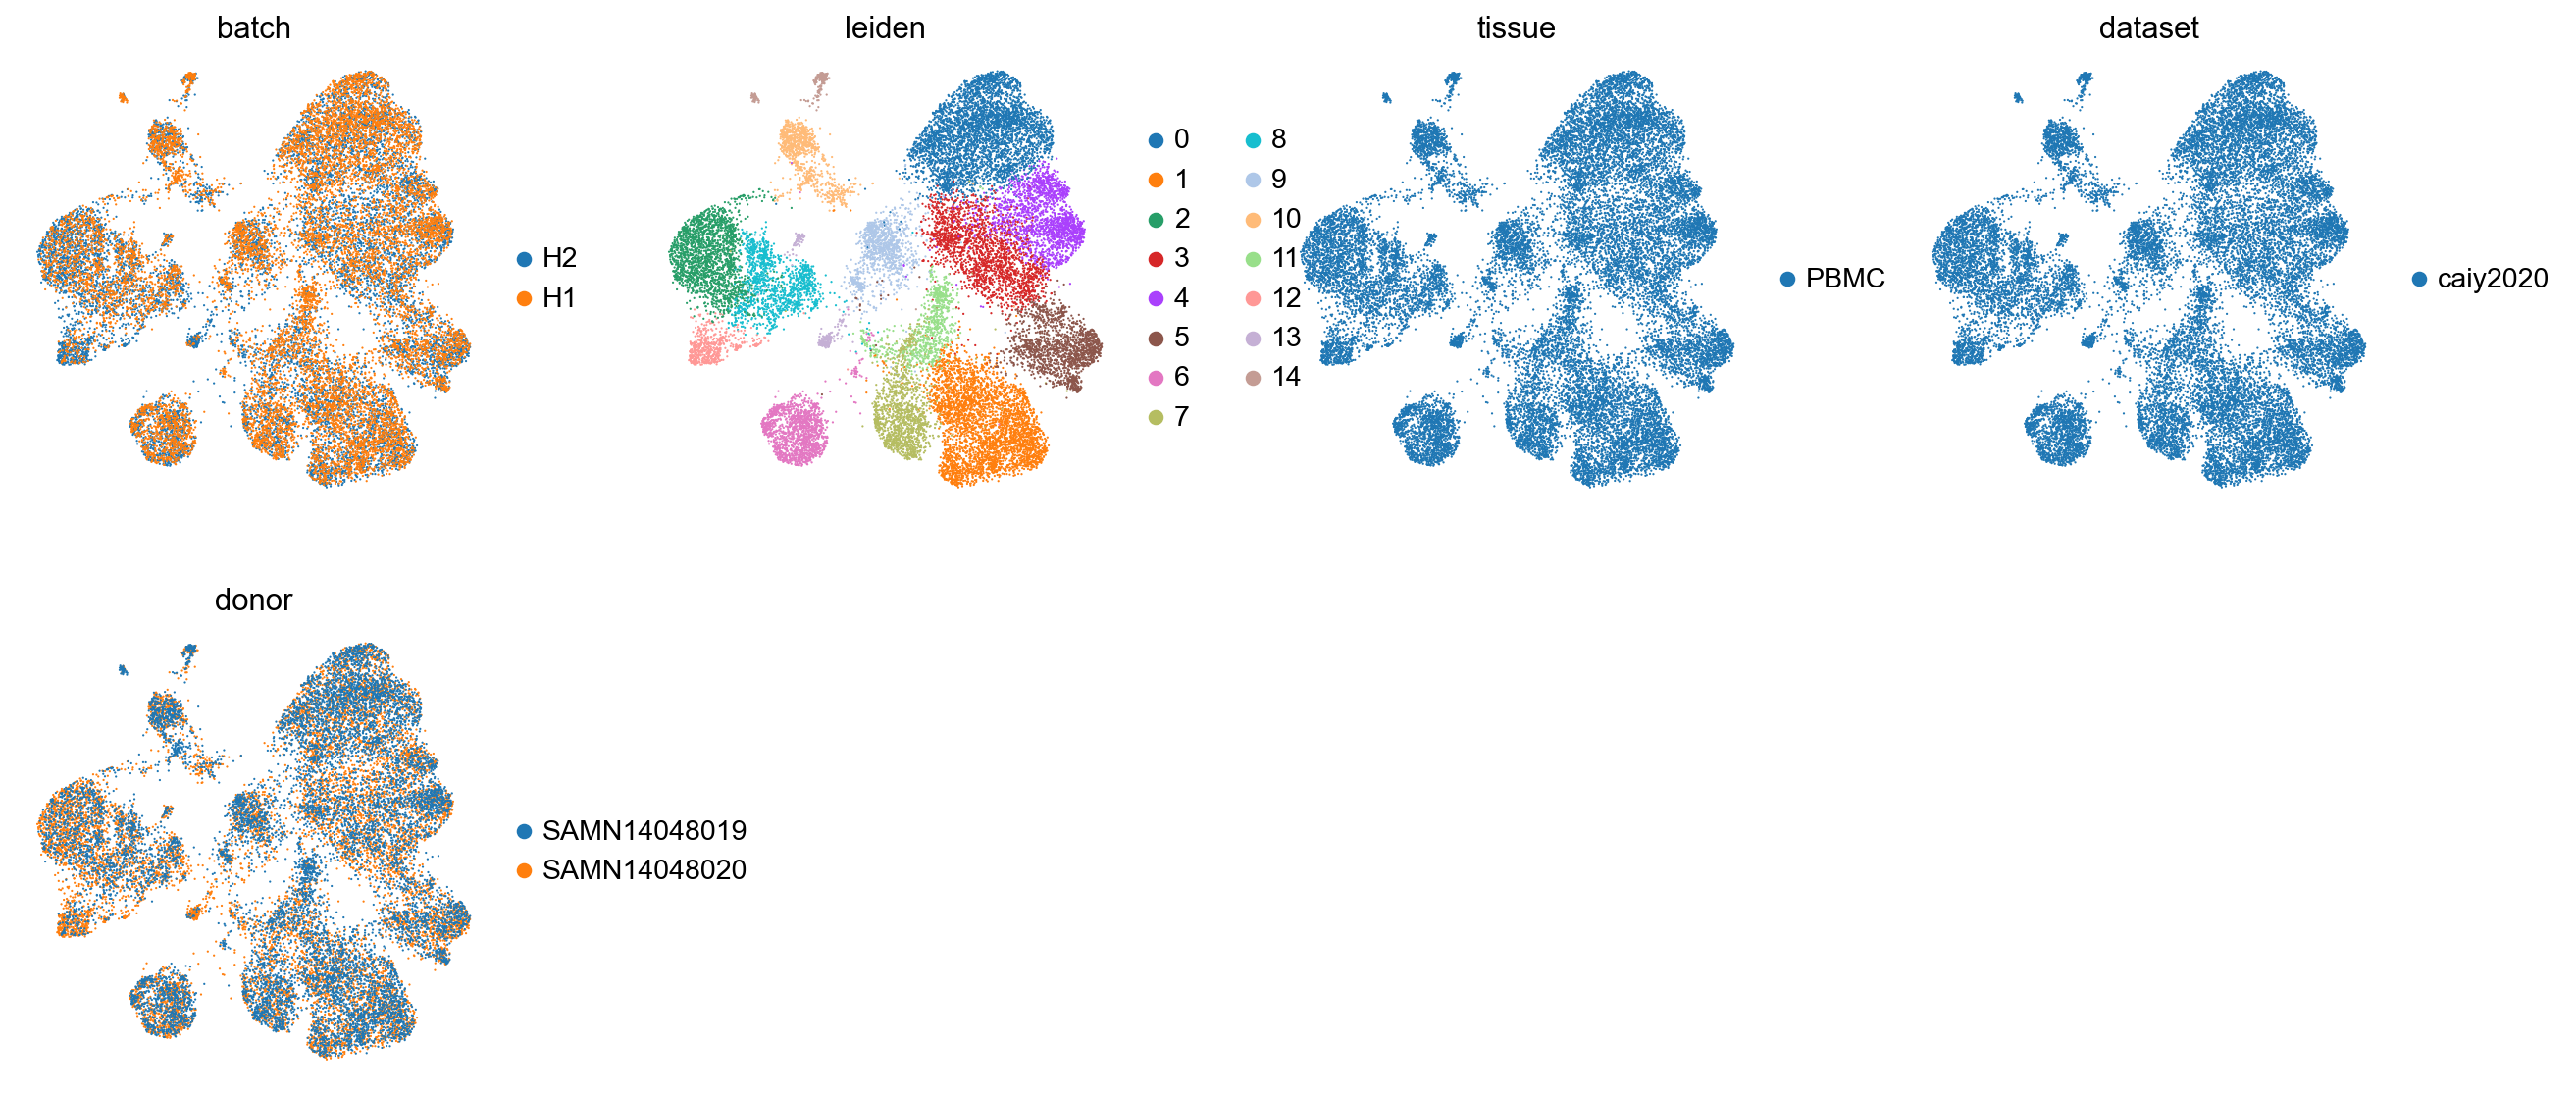

In [40]:
sc.pl.umap(
    adata,
    color=["batch", "leiden", "tissue", "dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


#### Model 3

In [41]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [42]:
vae_3 = scvi.model.SCVI(adata, n_layers=3, n_latent=50, gene_likelihood="nb", dispersion="gene-batch")

In [43]:
scvi.model.SCVI.view_anndata_setup(vae_3)

Anndata setup with scvi-tools version 0.20.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 22049 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 3000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     H2     │          0          │
│                    │     H1     │          1          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [44]:
vae_3.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/363:   0%|          | 0/363 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/363:   0%|          | 1/363 [00:07<47:47,  7.92s/it, loss=1.75e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/363:   1%|          | 2/363 [00:15<46:01,  7.65s/it, loss=1.73e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/363:   1%|          | 3/363 [00:22<44:59,  7.50s/it, loss=1.7e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/363:   1%|          | 4/363 [00:30<44:52,  7.50s/it, loss=1.71e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/363:   1%|▏         | 5/363 [00:37<44:50,  7.51s/it, loss=1.69e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/363:   2%|▏         | 6/363 [00:45<44:46,  7.53s/it, loss=1.7e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/363:   2%|▏         | 7/363 [00:53<45:16,  7.63s/it, loss=1.69e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/363:   2%|▏         | 8/363 [01:00<44:41,  7.55s/it, loss=1.69e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/363:   2%|▏         | 9/363 [01:08<44:55,  7.61s/it, loss=1.68e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/363:   3%|▎         | 10/363 [01:15<44:26,  7.55s/it, loss=1.7e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/363:   3%|▎         | 11/363 [01:22<43:48,  7.47s/it, loss=1.65e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/363:   3%|▎         | 12/363 [01:31<44:44,  7.65s/it, loss=1.68e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/363:   4%|▎         | 13/363 [01:38<44:52,  7.69s/it, loss=1.65e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/363:   4%|▍         | 14/363 [01:46<45:05,  7.75s/it, loss=1.66e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/363:   4%|▍         | 15/363 [01:53<43:56,  7.58s/it, loss=1.64e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/363:   4%|▍         | 16/363 [02:01<43:13,  7.48s/it, loss=1.64e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/363:   5%|▍         | 17/363 [02:08<42:42,  7.41s/it, loss=1.65e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/363:   5%|▍         | 18/363 [02:15<42:01,  7.31s/it, loss=1.64e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/363:   5%|▌         | 19/363 [02:22<41:35,  7.26s/it, loss=1.64e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/363:   6%|▌         | 20/363 [02:30<42:53,  7.50s/it, loss=1.62e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/363:   6%|▌         | 21/363 [02:38<42:41,  7.49s/it, loss=1.64e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/363:   6%|▌         | 22/363 [02:45<42:31,  7.48s/it, loss=1.61e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/363:   6%|▋         | 23/363 [02:52<42:00,  7.41s/it, loss=1.62e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/363:   7%|▋         | 24/363 [02:59<41:21,  7.32s/it, loss=1.63e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/363:   7%|▋         | 25/363 [03:07<41:35,  7.38s/it, loss=1.63e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/363:   7%|▋         | 26/363 [03:14<40:56,  7.29s/it, loss=1.61e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/363:   7%|▋         | 27/363 [03:21<40:40,  7.26s/it, loss=1.63e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/363:   8%|▊         | 28/363 [03:28<40:29,  7.25s/it, loss=1.6e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/363:   8%|▊         | 29/363 [03:36<41:33,  7.47s/it, loss=1.6e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/363:   8%|▊         | 30/363 [03:44<41:30,  7.48s/it, loss=1.61e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/363:   9%|▊         | 31/363 [03:52<42:16,  7.64s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/363:   9%|▉         | 32/363 [03:59<41:43,  7.56s/it, loss=1.6e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/363:   9%|▉         | 33/363 [04:07<41:28,  7.54s/it, loss=1.6e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/363:   9%|▉         | 34/363 [04:14<40:57,  7.47s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/363:  10%|▉         | 35/363 [04:22<41:09,  7.53s/it, loss=1.6e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/363:  10%|▉         | 36/363 [04:29<40:44,  7.48s/it, loss=1.6e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/363:  10%|█         | 37/363 [04:37<40:24,  7.44s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/363:  10%|█         | 38/363 [04:44<40:36,  7.50s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/363:  11%|█         | 39/363 [04:52<40:19,  7.47s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/363:  11%|█         | 40/363 [04:59<39:53,  7.41s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/363:  11%|█▏        | 41/363 [05:06<39:38,  7.39s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/363:  12%|█▏        | 42/363 [05:13<39:23,  7.36s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/363:  12%|█▏        | 43/363 [05:21<39:16,  7.36s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/363:  12%|█▏        | 44/363 [05:28<39:01,  7.34s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/363:  12%|█▏        | 45/363 [05:36<39:05,  7.37s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/363:  13%|█▎        | 46/363 [05:43<39:07,  7.40s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/363:  13%|█▎        | 47/363 [05:50<38:45,  7.36s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/363:  13%|█▎        | 48/363 [05:58<38:24,  7.32s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/363:  13%|█▎        | 49/363 [06:05<38:30,  7.36s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/363:  14%|█▍        | 50/363 [06:12<38:37,  7.40s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/363:  14%|█▍        | 51/363 [06:20<38:28,  7.40s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/363:  14%|█▍        | 52/363 [06:27<38:26,  7.42s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/363:  15%|█▍        | 53/363 [06:35<38:38,  7.48s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/363:  15%|█▍        | 54/363 [06:42<38:31,  7.48s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/363:  15%|█▌        | 55/363 [06:50<39:14,  7.64s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/363:  15%|█▌        | 56/363 [06:58<38:52,  7.60s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/363:  16%|█▌        | 57/363 [07:06<38:46,  7.60s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/363:  16%|█▌        | 58/363 [07:13<38:21,  7.54s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/363:  16%|█▋        | 59/363 [07:20<38:11,  7.54s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/363:  17%|█▋        | 60/363 [07:28<38:11,  7.56s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/363:  17%|█▋        | 61/363 [07:36<38:25,  7.63s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/363:  17%|█▋        | 62/363 [07:44<39:21,  7.85s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/363:  17%|█▋        | 63/363 [07:52<39:11,  7.84s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/363:  18%|█▊        | 64/363 [07:59<38:17,  7.68s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/363:  18%|█▊        | 65/363 [08:07<37:39,  7.58s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/363:  18%|█▊        | 66/363 [08:14<37:13,  7.52s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/363:  18%|█▊        | 67/363 [08:22<36:54,  7.48s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/363:  19%|█▊        | 68/363 [08:29<36:38,  7.45s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/363:  19%|█▉        | 69/363 [08:36<36:44,  7.50s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/363:  19%|█▉        | 70/363 [08:44<36:27,  7.47s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/363:  20%|█▉        | 71/363 [08:51<36:16,  7.45s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/363:  20%|█▉        | 72/363 [08:59<36:17,  7.48s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/363:  20%|██        | 73/363 [09:06<36:11,  7.49s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/363:  20%|██        | 74/363 [09:14<36:14,  7.52s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/363:  21%|██        | 75/363 [09:21<35:48,  7.46s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/363:  21%|██        | 76/363 [09:29<35:49,  7.49s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/363:  21%|██        | 77/363 [09:36<35:46,  7.50s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/363:  21%|██▏       | 78/363 [09:44<35:27,  7.46s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/363:  22%|██▏       | 79/363 [09:51<35:05,  7.41s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/363:  22%|██▏       | 80/363 [09:59<35:16,  7.48s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/363:  22%|██▏       | 81/363 [10:06<35:15,  7.50s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/363:  23%|██▎       | 82/363 [10:14<34:58,  7.47s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/363:  23%|██▎       | 83/363 [10:21<34:43,  7.44s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/363:  23%|██▎       | 84/363 [10:29<34:42,  7.46s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/363:  23%|██▎       | 85/363 [10:36<34:23,  7.42s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/363:  24%|██▎       | 86/363 [10:43<34:07,  7.39s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/363:  24%|██▍       | 87/363 [10:51<34:26,  7.49s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/363:  24%|██▍       | 88/363 [10:58<34:08,  7.45s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/363:  25%|██▍       | 89/363 [11:06<34:21,  7.52s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/363:  25%|██▍       | 90/363 [11:14<34:38,  7.61s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/363:  25%|██▌       | 91/363 [11:21<34:26,  7.60s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/363:  25%|██▌       | 92/363 [11:29<34:24,  7.62s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/363:  26%|██▌       | 93/363 [11:37<34:10,  7.60s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/363:  26%|██▌       | 94/363 [11:44<33:55,  7.57s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/363:  26%|██▌       | 95/363 [11:52<33:55,  7.60s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/363:  26%|██▋       | 96/363 [11:59<33:26,  7.52s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/363:  27%|██▋       | 97/363 [12:07<33:33,  7.57s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/363:  27%|██▋       | 98/363 [12:14<33:25,  7.57s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/363:  27%|██▋       | 99/363 [12:22<33:22,  7.59s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 101/363:  28%|██▊       | 100/363 [12:29<33:11,  7.57s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 102/363:  28%|██▊       | 101/363 [12:37<33:17,  7.63s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 103/363:  28%|██▊       | 102/363 [12:45<33:21,  7.67s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 104/363:  28%|██▊       | 103/363 [12:53<33:12,  7.66s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 105/363:  29%|██▊       | 104/363 [13:00<33:00,  7.65s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 106/363:  29%|██▉       | 105/363 [13:08<32:39,  7.59s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 107/363:  29%|██▉       | 106/363 [13:15<32:17,  7.54s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 108/363:  29%|██▉       | 107/363 [13:24<34:21,  8.05s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 109/363:  30%|██▉       | 108/363 [13:32<34:18,  8.07s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 110/363:  30%|███       | 109/363 [13:40<34:07,  8.06s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 111/363:  30%|███       | 110/363 [13:48<32:52,  7.79s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 112/363:  31%|███       | 111/363 [13:55<32:33,  7.75s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 113/363:  31%|███       | 112/363 [14:03<32:06,  7.68s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 114/363:  31%|███       | 113/363 [14:10<31:26,  7.54s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 115/363:  31%|███▏      | 114/363 [14:19<33:37,  8.10s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 116/363:  32%|███▏      | 115/363 [14:27<32:23,  7.84s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 117/363:  32%|███▏      | 116/363 [14:34<31:46,  7.72s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 118/363:  32%|███▏      | 117/363 [14:42<31:53,  7.78s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 119/363:  33%|███▎      | 118/363 [14:49<31:12,  7.64s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 120/363:  33%|███▎      | 119/363 [14:58<32:33,  8.01s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 121/363:  33%|███▎      | 120/363 [15:06<31:59,  7.90s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 122/363:  33%|███▎      | 121/363 [15:14<31:54,  7.91s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 123/363:  34%|███▎      | 122/363 [15:22<31:47,  7.92s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 124/363:  34%|███▍      | 123/363 [15:30<31:40,  7.92s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 125/363:  34%|███▍      | 124/363 [15:37<31:13,  7.84s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 126/363:  34%|███▍      | 125/363 [15:45<31:09,  7.86s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 127/363:  35%|███▍      | 126/363 [15:53<30:42,  7.77s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 128/363:  35%|███▍      | 127/363 [16:01<31:03,  7.89s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/363:  35%|███▌      | 128/363 [16:09<30:34,  7.80s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 130/363:  36%|███▌      | 129/363 [16:16<30:21,  7.78s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 131/363:  36%|███▌      | 130/363 [16:24<29:36,  7.62s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 132/363:  36%|███▌      | 131/363 [16:31<29:49,  7.71s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 133/363:  36%|███▋      | 132/363 [16:39<29:45,  7.73s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 134/363:  37%|███▋      | 133/363 [16:46<29:00,  7.57s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 135/363:  37%|███▋      | 134/363 [16:55<29:44,  7.79s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 136/363:  37%|███▋      | 135/363 [17:03<30:04,  7.91s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 137/363:  37%|███▋      | 136/363 [17:12<31:06,  8.22s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 138/363:  38%|███▊      | 137/363 [17:20<30:40,  8.14s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 139/363:  38%|███▊      | 138/363 [17:27<29:42,  7.92s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 140/363:  38%|███▊      | 139/363 [17:34<28:44,  7.70s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 141/363:  39%|███▊      | 140/363 [17:42<28:10,  7.58s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 142/363:  39%|███▉      | 141/363 [17:49<27:40,  7.48s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 143/363:  39%|███▉      | 142/363 [17:56<27:33,  7.48s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 144/363:  39%|███▉      | 143/363 [18:07<31:04,  8.47s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 145/363:  40%|███▉      | 144/363 [18:16<30:55,  8.47s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 146/363:  40%|███▉      | 145/363 [18:24<30:07,  8.29s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 147/363:  40%|████      | 146/363 [18:32<30:17,  8.37s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 148/363:  40%|████      | 147/363 [18:39<28:56,  8.04s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 149/363:  41%|████      | 148/363 [18:47<27:55,  7.79s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 150/363:  41%|████      | 149/363 [18:54<27:22,  7.67s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 151/363:  41%|████▏     | 150/363 [19:04<29:45,  8.38s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 152/363:  42%|████▏     | 151/363 [19:11<28:29,  8.06s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 153/363:  42%|████▏     | 152/363 [19:21<29:32,  8.40s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 154/363:  42%|████▏     | 153/363 [19:31<31:01,  8.86s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 155/363:  42%|████▏     | 154/363 [19:39<30:01,  8.62s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 156/363:  43%|████▎     | 155/363 [19:46<28:31,  8.23s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 157/363:  43%|████▎     | 156/363 [19:53<27:16,  7.90s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 158/363:  43%|████▎     | 157/363 [20:00<26:31,  7.72s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 159/363:  44%|████▎     | 158/363 [20:08<26:12,  7.67s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 160/363:  44%|████▍     | 159/363 [20:15<25:46,  7.58s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/363:  44%|████▍     | 160/363 [20:22<25:12,  7.45s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 162/363:  44%|████▍     | 161/363 [20:29<24:42,  7.34s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 163/363:  45%|████▍     | 162/363 [20:37<24:22,  7.27s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 164/363:  45%|████▍     | 163/363 [20:44<24:03,  7.22s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 165/363:  45%|████▌     | 164/363 [20:51<23:56,  7.22s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 166/363:  45%|████▌     | 165/363 [20:58<23:41,  7.18s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 167/363:  46%|████▌     | 166/363 [21:05<23:27,  7.14s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 168/363:  46%|████▌     | 167/363 [21:12<23:14,  7.11s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 169/363:  46%|████▋     | 168/363 [21:19<23:03,  7.10s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 170/363:  47%|████▋     | 169/363 [21:26<22:55,  7.09s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 171/363:  47%|████▋     | 170/363 [21:34<23:05,  7.18s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 172/363:  47%|████▋     | 171/363 [21:41<22:44,  7.11s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 173/363:  47%|████▋     | 172/363 [21:48<22:36,  7.10s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 174/363:  48%|████▊     | 173/363 [21:55<22:26,  7.09s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 175/363:  48%|████▊     | 174/363 [22:02<22:19,  7.08s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 176/363:  48%|████▊     | 175/363 [22:09<22:11,  7.08s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 177/363:  48%|████▊     | 176/363 [22:16<22:01,  7.06s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 178/363:  49%|████▉     | 177/363 [22:23<21:49,  7.04s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 179/363:  49%|████▉     | 178/363 [22:30<21:38,  7.02s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 180/363:  49%|████▉     | 179/363 [22:37<21:30,  7.01s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 181/363:  50%|████▉     | 180/363 [22:44<21:23,  7.01s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 182/363:  50%|████▉     | 181/363 [22:51<21:14,  7.00s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 183/363:  50%|█████     | 182/363 [22:58<21:12,  7.03s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 184/363:  50%|█████     | 183/363 [23:05<21:04,  7.03s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 185/363:  51%|█████     | 184/363 [23:12<20:57,  7.02s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 186/363:  51%|█████     | 185/363 [23:19<20:49,  7.02s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 187/363:  51%|█████     | 186/363 [23:26<20:48,  7.05s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 188/363:  52%|█████▏    | 187/363 [23:33<20:41,  7.05s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 189/363:  52%|█████▏    | 188/363 [23:40<20:32,  7.05s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 190/363:  52%|█████▏    | 189/363 [23:47<20:24,  7.04s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 191/363:  52%|█████▏    | 190/363 [23:54<20:19,  7.05s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 192/363:  53%|█████▎    | 191/363 [24:01<20:11,  7.04s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 193/363:  53%|█████▎    | 192/363 [24:08<20:12,  7.09s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 194/363:  53%|█████▎    | 193/363 [24:16<20:05,  7.09s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 195/363:  53%|█████▎    | 194/363 [24:23<19:55,  7.07s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 196/363:  54%|█████▎    | 195/363 [24:30<19:47,  7.07s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 197/363:  54%|█████▍    | 196/363 [24:37<19:42,  7.08s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 198/363:  54%|█████▍    | 197/363 [24:44<19:32,  7.07s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 199/363:  55%|█████▍    | 198/363 [24:51<19:25,  7.06s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/363:  55%|█████▍    | 199/363 [24:58<19:18,  7.06s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 201/363:  55%|█████▌    | 200/363 [25:05<19:15,  7.09s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 202/363:  55%|█████▌    | 201/363 [25:12<19:12,  7.12s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 203/363:  56%|█████▌    | 202/363 [25:20<19:29,  7.26s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 204/363:  56%|█████▌    | 203/363 [25:27<19:21,  7.26s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 205/363:  56%|█████▌    | 204/363 [25:34<19:10,  7.24s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 206/363:  56%|█████▋    | 205/363 [25:41<18:56,  7.20s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 207/363:  57%|█████▋    | 206/363 [25:49<18:51,  7.21s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 208/363:  57%|█████▋    | 207/363 [25:56<19:08,  7.36s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 209/363:  57%|█████▋    | 208/363 [26:04<18:57,  7.34s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 210/363:  58%|█████▊    | 209/363 [26:11<18:54,  7.37s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 211/363:  58%|█████▊    | 210/363 [26:18<18:33,  7.28s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 212/363:  58%|█████▊    | 211/363 [26:25<18:22,  7.25s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 213/363:  58%|█████▊    | 212/363 [26:32<18:02,  7.17s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 214/363:  59%|█████▊    | 213/363 [26:39<17:47,  7.12s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 215/363:  59%|█████▉    | 214/363 [26:47<17:46,  7.16s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 216/363:  59%|█████▉    | 215/363 [26:54<17:50,  7.24s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 217/363:  60%|█████▉    | 216/363 [27:02<18:30,  7.55s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 218/363:  60%|█████▉    | 217/363 [27:09<18:04,  7.43s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 219/363:  60%|██████    | 218/363 [27:17<18:20,  7.59s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 220/363:  60%|██████    | 219/363 [27:24<17:43,  7.39s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 221/363:  61%|██████    | 220/363 [27:32<17:43,  7.44s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 222/363:  61%|██████    | 221/363 [27:40<18:09,  7.68s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 223/363:  61%|██████    | 222/363 [27:48<18:16,  7.78s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 224/363:  61%|██████▏   | 223/363 [27:56<17:58,  7.70s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 225/363:  62%|██████▏   | 224/363 [28:03<17:27,  7.54s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 226/363:  62%|██████▏   | 225/363 [28:10<17:19,  7.54s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 227/363:  62%|██████▏   | 226/363 [28:18<17:02,  7.46s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 228/363:  63%|██████▎   | 227/363 [28:26<17:16,  7.62s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 229/363:  63%|██████▎   | 228/363 [28:33<16:58,  7.55s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 230/363:  63%|██████▎   | 229/363 [28:41<16:50,  7.54s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 231/363:  63%|██████▎   | 230/363 [28:48<16:36,  7.49s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 232/363:  64%|██████▎   | 231/363 [28:55<16:31,  7.51s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 233/363:  64%|██████▍   | 232/363 [29:03<16:23,  7.51s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 234/363:  64%|██████▍   | 233/363 [29:10<16:13,  7.49s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 235/363:  64%|██████▍   | 234/363 [29:18<16:09,  7.51s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 236/363:  65%|██████▍   | 235/363 [29:25<16:00,  7.50s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 237/363:  65%|██████▌   | 236/363 [29:33<15:49,  7.48s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 238/363:  65%|██████▌   | 237/363 [29:40<15:37,  7.44s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 239/363:  66%|██████▌   | 238/363 [29:47<15:22,  7.38s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 240/363:  66%|██████▌   | 239/363 [29:55<15:20,  7.42s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 241/363:  66%|██████▌   | 240/363 [30:03<15:19,  7.48s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 242/363:  66%|██████▋   | 241/363 [30:10<15:10,  7.47s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 243/363:  67%|██████▋   | 242/363 [30:17<14:51,  7.37s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 244/363:  67%|██████▋   | 243/363 [30:24<14:41,  7.35s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 245/363:  67%|██████▋   | 244/363 [30:32<14:34,  7.35s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 246/363:  67%|██████▋   | 245/363 [30:44<17:25,  8.86s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 247/363:  68%|██████▊   | 246/363 [30:52<16:34,  8.50s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 248/363:  68%|██████▊   | 247/363 [30:59<15:36,  8.07s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 249/363:  68%|██████▊   | 248/363 [31:06<14:57,  7.81s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 250/363:  69%|██████▊   | 249/363 [31:13<14:32,  7.65s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 251/363:  69%|██████▉   | 250/363 [31:21<14:08,  7.51s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 252/363:  69%|██████▉   | 251/363 [31:28<13:53,  7.44s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 253/363:  69%|██████▉   | 252/363 [31:35<13:36,  7.35s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 254/363:  70%|██████▉   | 253/363 [31:42<13:21,  7.28s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 255/363:  70%|██████▉   | 254/363 [31:49<13:07,  7.23s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 256/363:  70%|███████   | 255/363 [31:56<12:53,  7.16s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 257/363:  71%|███████   | 256/363 [32:03<12:45,  7.15s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 258/363:  71%|███████   | 257/363 [32:11<12:39,  7.17s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 259/363:  71%|███████   | 258/363 [32:18<12:26,  7.11s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 260/363:  71%|███████▏  | 259/363 [32:25<12:21,  7.13s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 261/363:  72%|███████▏  | 260/363 [32:32<12:10,  7.09s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 262/363:  72%|███████▏  | 261/363 [32:39<12:03,  7.09s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 263/363:  72%|███████▏  | 262/363 [32:46<11:55,  7.09s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 264/363:  72%|███████▏  | 263/363 [32:53<11:49,  7.10s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 265/363:  73%|███████▎  | 264/363 [33:00<11:43,  7.11s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 266/363:  73%|███████▎  | 265/363 [33:07<11:37,  7.12s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 267/363:  73%|███████▎  | 266/363 [33:14<11:33,  7.15s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 268/363:  74%|███████▎  | 267/363 [33:21<11:21,  7.10s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 269/363:  74%|███████▍  | 268/363 [33:28<11:12,  7.08s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 270/363:  74%|███████▍  | 269/363 [33:36<11:12,  7.15s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 271/363:  74%|███████▍  | 270/363 [33:43<11:04,  7.14s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 272/363:  75%|███████▍  | 271/363 [33:50<10:54,  7.12s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 273/363:  75%|███████▍  | 272/363 [33:57<10:48,  7.12s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 274/363:  75%|███████▌  | 273/363 [34:04<10:39,  7.11s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 275/363:  75%|███████▌  | 274/363 [34:11<10:31,  7.10s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 276/363:  76%|███████▌  | 275/363 [34:18<10:25,  7.11s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 277/363:  76%|███████▌  | 276/363 [34:26<10:18,  7.11s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 278/363:  76%|███████▋  | 277/363 [34:33<10:11,  7.11s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 279/363:  77%|███████▋  | 278/363 [34:40<10:01,  7.07s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 280/363:  77%|███████▋  | 279/363 [34:47<09:56,  7.10s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 281/363:  77%|███████▋  | 280/363 [34:54<09:47,  7.08s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 282/363:  77%|███████▋  | 281/363 [35:01<09:41,  7.09s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 283/363:  78%|███████▊  | 282/363 [35:08<09:40,  7.17s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 284/363:  78%|███████▊  | 283/363 [35:15<09:33,  7.17s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 285/363:  78%|███████▊  | 284/363 [35:23<09:27,  7.18s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 286/363:  79%|███████▊  | 285/363 [35:30<09:20,  7.18s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 287/363:  79%|███████▉  | 286/363 [35:37<09:15,  7.21s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 288/363:  79%|███████▉  | 287/363 [35:44<09:04,  7.16s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 289/363:  79%|███████▉  | 288/363 [35:51<08:58,  7.18s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 290/363:  80%|███████▉  | 289/363 [35:59<08:53,  7.21s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 291/363:  80%|███████▉  | 290/363 [36:06<08:45,  7.20s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 292/363:  80%|████████  | 291/363 [36:13<08:34,  7.15s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 293/363:  80%|████████  | 292/363 [36:20<08:27,  7.14s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 294/363:  81%|████████  | 293/363 [36:27<08:20,  7.15s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 295/363:  81%|████████  | 294/363 [36:35<08:18,  7.23s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 296/363:  81%|████████▏ | 295/363 [36:42<08:10,  7.21s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 297/363:  82%|████████▏ | 296/363 [36:49<07:58,  7.14s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 298/363:  82%|████████▏ | 297/363 [36:56<07:53,  7.17s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 299/363:  82%|████████▏ | 298/363 [37:03<07:44,  7.15s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 300/363:  82%|████████▏ | 299/363 [37:10<07:36,  7.13s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 301/363:  83%|████████▎ | 300/363 [37:17<07:28,  7.12s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 302/363:  83%|████████▎ | 301/363 [37:24<07:19,  7.09s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 303/363:  83%|████████▎ | 302/363 [37:32<07:14,  7.13s/it, loss=1.54e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 304/363:  83%|████████▎ | 303/363 [37:39<07:09,  7.16s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 305/363:  84%|████████▎ | 304/363 [37:46<07:00,  7.12s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 306/363:  84%|████████▍ | 305/363 [37:53<06:58,  7.21s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 307/363:  84%|████████▍ | 306/363 [38:00<06:49,  7.18s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 308/363:  85%|████████▍ | 307/363 [38:08<06:50,  7.32s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 309/363:  85%|████████▍ | 308/363 [38:17<07:15,  7.91s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 310/363:  85%|████████▌ | 309/363 [38:26<07:15,  8.07s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 311/363:  85%|████████▌ | 310/363 [38:34<07:13,  8.18s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 312/363:  86%|████████▌ | 311/363 [38:42<07:07,  8.22s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 313/363:  86%|████████▌ | 312/363 [38:52<07:15,  8.54s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 314/363:  86%|████████▌ | 313/363 [38:59<06:45,  8.11s/it, loss=1.59e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 315/363:  87%|████████▋ | 314/363 [39:08<06:46,  8.29s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 316/363:  87%|████████▋ | 315/363 [39:16<06:40,  8.35s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 317/363:  87%|████████▋ | 316/363 [39:24<06:32,  8.36s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 318/363:  87%|████████▋ | 317/363 [39:32<06:10,  8.05s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 319/363:  88%|████████▊ | 318/363 [39:39<05:50,  7.80s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 320/363:  88%|████████▊ | 319/363 [39:48<06:00,  8.20s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 321/363:  88%|████████▊ | 320/363 [39:57<06:05,  8.51s/it, loss=1.6e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 322/363:  88%|████████▊ | 321/363 [40:06<06:04,  8.67s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 323/363:  89%|████████▊ | 322/363 [40:15<05:51,  8.57s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 324/363:  89%|████████▉ | 323/363 [40:23<05:39,  8.49s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 325/363:  89%|████████▉ | 324/363 [40:30<05:18,  8.17s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 326/363:  90%|████████▉ | 325/363 [40:38<05:00,  7.89s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 327/363:  90%|████████▉ | 326/363 [40:45<04:50,  7.85s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 328/363:  90%|█████████ | 327/363 [40:53<04:37,  7.70s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 329/363:  90%|█████████ | 328/363 [41:01<04:31,  7.76s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 330/363:  91%|█████████ | 329/363 [41:08<04:21,  7.70s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 331/363:  91%|█████████ | 330/363 [41:16<04:10,  7.60s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 332/363:  91%|█████████ | 331/363 [41:23<03:59,  7.47s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 333/363:  91%|█████████▏| 332/363 [41:30<03:47,  7.35s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 334/363:  92%|█████████▏| 333/363 [41:37<03:40,  7.35s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 335/363:  92%|█████████▏| 334/363 [41:44<03:32,  7.31s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 336/363:  92%|█████████▏| 335/363 [41:52<03:25,  7.34s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 337/363:  93%|█████████▎| 336/363 [41:59<03:16,  7.27s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 338/363:  93%|█████████▎| 337/363 [42:06<03:09,  7.28s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 339/363:  93%|█████████▎| 338/363 [42:13<03:01,  7.26s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 340/363:  93%|█████████▎| 339/363 [42:21<02:54,  7.26s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 341/363:  94%|█████████▎| 340/363 [42:28<02:46,  7.24s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 342/363:  94%|█████████▍| 341/363 [42:35<02:38,  7.21s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 343/363:  94%|█████████▍| 342/363 [42:42<02:30,  7.18s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 344/363:  94%|█████████▍| 343/363 [42:49<02:22,  7.15s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 345/363:  95%|█████████▍| 344/363 [42:56<02:15,  7.11s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 346/363:  95%|█████████▌| 345/363 [43:04<02:08,  7.17s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 347/363:  95%|█████████▌| 346/363 [43:11<02:03,  7.24s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 348/363:  96%|█████████▌| 347/363 [43:23<02:16,  8.54s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 349/363:  96%|█████████▌| 348/363 [43:40<02:50, 11.37s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 350/363:  96%|█████████▌| 349/363 [43:55<02:51, 12.27s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 351/363:  96%|█████████▋| 350/363 [44:13<03:01, 13.97s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 352/363:  97%|█████████▋| 351/363 [44:21<02:26, 12.18s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 353/363:  97%|█████████▋| 352/363 [44:30<02:03, 11.25s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 354/363:  97%|█████████▋| 353/363 [44:43<01:56, 11.69s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 355/363:  98%|█████████▊| 354/363 [44:57<01:51, 12.38s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 356/363:  98%|█████████▊| 355/363 [45:12<01:46, 13.37s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 357/363:  98%|█████████▊| 356/363 [45:25<01:31, 13.10s/it, loss=1.6e+03, v_num=1] 

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 358/363:  98%|█████████▊| 357/363 [45:36<01:14, 12.48s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 359/363:  99%|█████████▊| 358/363 [45:49<01:03, 12.62s/it, loss=1.58e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 360/363:  99%|█████████▉| 359/363 [46:05<00:54, 13.71s/it, loss=1.57e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 361/363:  99%|█████████▉| 360/363 [46:15<00:37, 12.53s/it, loss=1.55e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 362/363:  99%|█████████▉| 361/363 [46:23<00:22, 11.27s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 363/363: 100%|█████████▉| 362/363 [46:31<00:10, 10.33s/it, loss=1.56e+03, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 363/363: 100%|██████████| 363/363 [46:38<00:00,  9.41s/it, loss=1.57e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=363` reached.


Epoch 363/363: 100%|██████████| 363/363 [46:38<00:00,  7.71s/it, loss=1.57e+03, v_num=1]


In [45]:
adata.obsm["X_scVI_3"] = vae_3.get_latent_representation()

In [46]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scVI_3")
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata, min_dist=0.5, spread=8, random_state=0)

/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [47]:
plt.figure(figsize = (5, 5))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

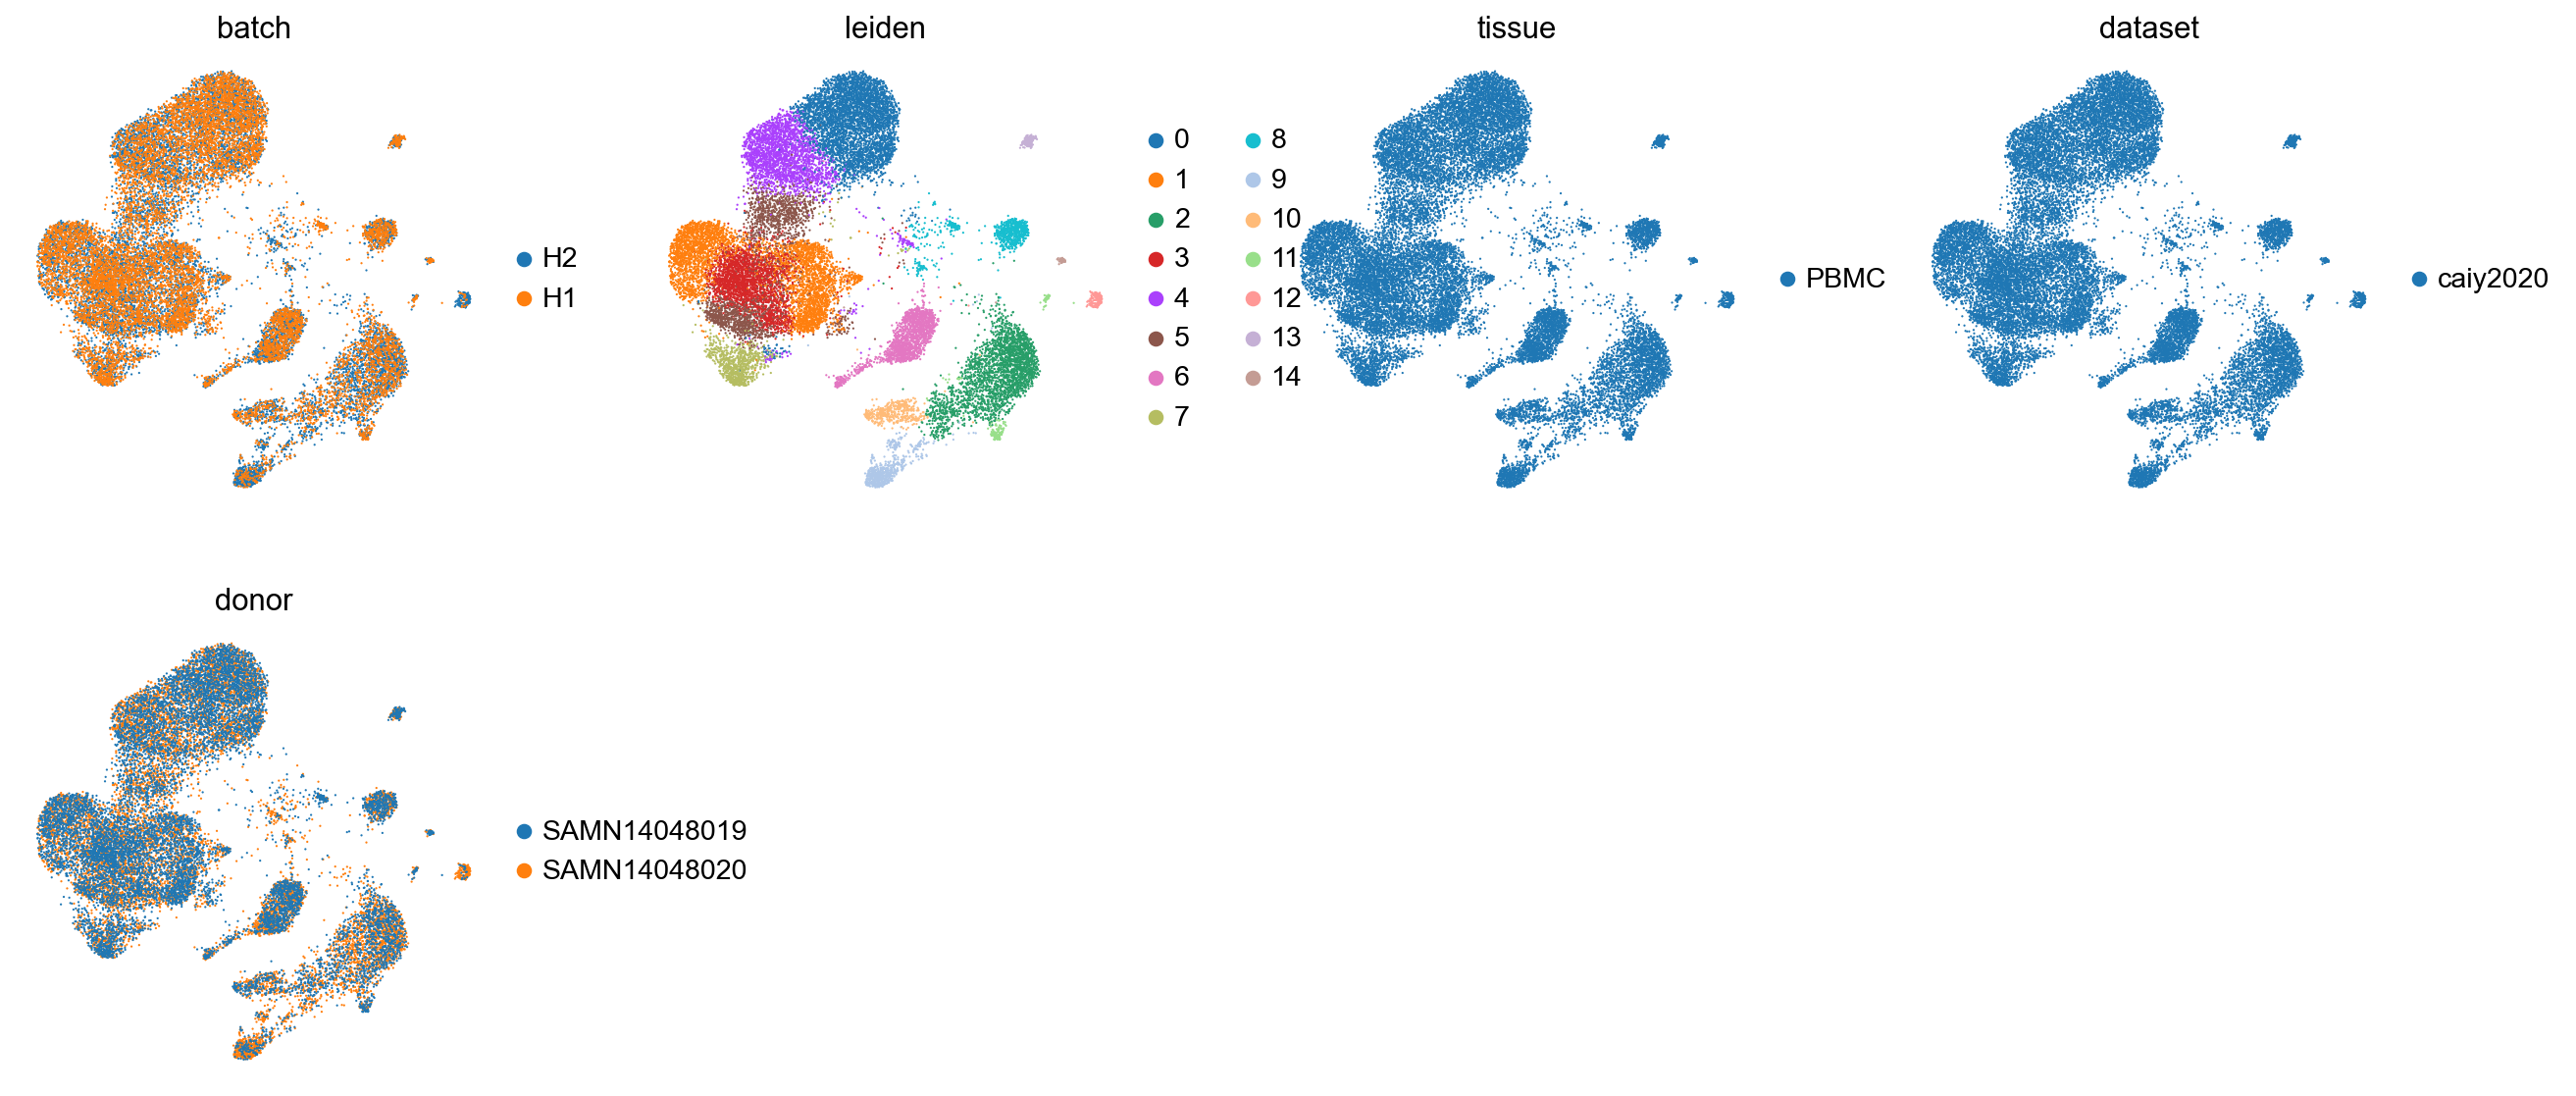

In [48]:
sc.pl.umap(
    adata,
    color=["batch", "leiden", "tissue", "dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


### Benchmarking using scVI

In [93]:
from scib_metrics.benchmark import Benchmarker

%matplotlib inline

In [94]:
adata.obs

study    individual     sample tissue  \
barcode                                                                   
AAACCTGAGATGGCGT-H2-caiy2020  CaiY_2021  SAMN14048020  PBMC_HC_2   PBMC   
AAACCTGAGATGTGTA-H2-caiy2020  CaiY_2021  SAMN14048020  PBMC_HC_2   PBMC   
AAACCTGAGCAACGGT-H2-caiy2020  CaiY_2021  SAMN14048020  PBMC_HC_2   PBMC   
AAACCTGAGCCATCGC-H2-caiy2020  CaiY_2021  SAMN14048020  PBMC_HC_2   PBMC   
AAACCTGAGGTGATTA-H2-caiy2020  CaiY_2021  SAMN14048020  PBMC_HC_2   PBMC   
...                                 ...           ...        ...    ...   
TTTGTCAGTCGCGGTT-H1-caiy2020  CaiY_2021  SAMN14048019  PBMC_HC_1   PBMC   
TTTGTCAGTCGCTTCT-H1-caiy2020  CaiY_2021  SAMN14048019  PBMC_HC_1   PBMC   
TTTGTCAGTTCGAATC-H1-caiy2020  CaiY_2021  SAMN14048019  PBMC_HC_1   PBMC   
TTTGTCAGTTTGGGCC-H1-caiy2020  CaiY_2021  SAMN14048019  PBMC_HC_1   PBMC   
TTTGTCATCCCATTAT-H1-caiy2020  CaiY_2021  SAMN14048019  PBMC_HC_1   PBMC   

                                     donor age gender   status data_type  \
barcode                                                                    
AAACCTGAGATGGCGT-H2-caiy2020  SAMN14048020  30   male  Healthy  scRNAseq   
AAACCTGAGATGTGTA-H2-caiy2020  SAMN14048020  30   male  Healthy  scRNAseq   
AAACCTGAGCAACGGT-H2-caiy2020  SAMN14048020  30   male  Healthy  scRNAseq   
AAACCTGAGCCATCGC-H2-caiy2020  SAMN14048020  30   male  Healthy  scRNAseq   
AAACCTGAGGTGATTA-H2-caiy2020  SAMN14048020  30   male  Healthy  scRNAseq   
...                                    ...  ..    ...      ...       ...   
TTTGTCAGTCGCGGTT-H1-caiy2020  SAMN14048019  26   male  Healthy  scRNAseq   
TTTGTCAGTCGCTTCT-H1-caiy2020  SAMN14048019  26   male  Healthy  scRNAseq   
TTTGTCAGTTCGAATC-H1-caiy2020  SAMN14048019  26   male  Healthy  scRNAseq   
TTTGTCAGTTTGGGCC-H1-caiy2020  SAMN14048019  26   male  Healthy  scRNAseq   
TTTGTCATCCCATTAT-H1-caiy2020  SAMN14048019  26   male  Healthy  scRNAseq   

                                           centre  ... XIST-counts   S_score  \
barcode                                            ...                         
AAACCTGAGATGGCGT-H2-caiy2020  Shenzhen University  ...         0.0 -0.274516   
AAACCTGAGATGTGTA-H2-caiy2020  Shenzhen University  ...         0.0 -0.291798   
AAACCTGAGCAACGGT-H2-caiy2020  Shenzhen University  ...         0.0 -0.315739   
AAACCTGAGCCATCGC-H2-caiy2020  Shenzhen University  ...         0.0  0.037617   
AAACCTGAGGTGATTA-H2-caiy2020  Shenzhen University  ...         0.0  0.001693   
...                                           ...  ...         ...       ...   
TTTGTCAGTCGCGGTT-H1-caiy2020  Shenzhen University  ...         0.0 -0.165353   
TTTGTCAGTCGCTTCT-H1-caiy2020  Shenzhen University  ...         0.0 -0.177318   
TTTGTCAGTTCGAATC-H1-caiy2020  Shenzhen University  ...         0.0 -0.235875   
TTTGTCAGTTTGGGCC-H1-caiy2020  Shenzhen University  ...         0.0 -0.050351   
TTTGTCATCCCATTAT-H1-caiy2020  Shenzhen University  ...         0.0  0.080008   

                              G2M_score  predicted_doublets  object  protocol  \
barcode                                                                         
AAACCTGAGATGGCGT-H2-caiy2020  -0.168208                 0.0     NaN       NaN   
AAACCTGAGATGTGTA-H2-caiy2020  -0.157942                 0.0     NaN       NaN   
AAACCTGAGCAACGGT-H2-caiy2020   0.098983                 0.0     NaN       NaN   
AAACCTGAGCCATCGC-H2-caiy2020   0.046320                 0.0     NaN       NaN   
AAACCTGAGGTGATTA-H2-caiy2020  -0.202441                 0.0     NaN       NaN   
...                                 ...                 ...     ...       ...   
TTTGTCAGTCGCGGTT-H1-caiy2020  -0.250572                 0.0     NaN       NaN   
TTTGTCAGTCGCTTCT-H1-caiy2020  -0.173327                 0.0     NaN       NaN   
TTTGTCAGTTCGAATC-H1-caiy2020  -0.013744                 0.0     NaN       NaN   
TTTGTCAGTTTGGGCC-H1-caiy2020   0.022269                 0.0     NaN       NaN   
TTTGTCATCCCATTAT-H1-caiy2020   0.039641                 

In [95]:
bm = Benchmarker(adata, 
                 batch_key="batch", 
                 label_key="leiden",
                 embedding_obsm_keys=["X_scVI_1", "X_scVI_2", "X_scVI_3"],
                 n_jobs=1,
                 )



bm.benchmark()

Embeddings: 100%|██████████| 8/8 [20:37<00:00, 154.72s/it]


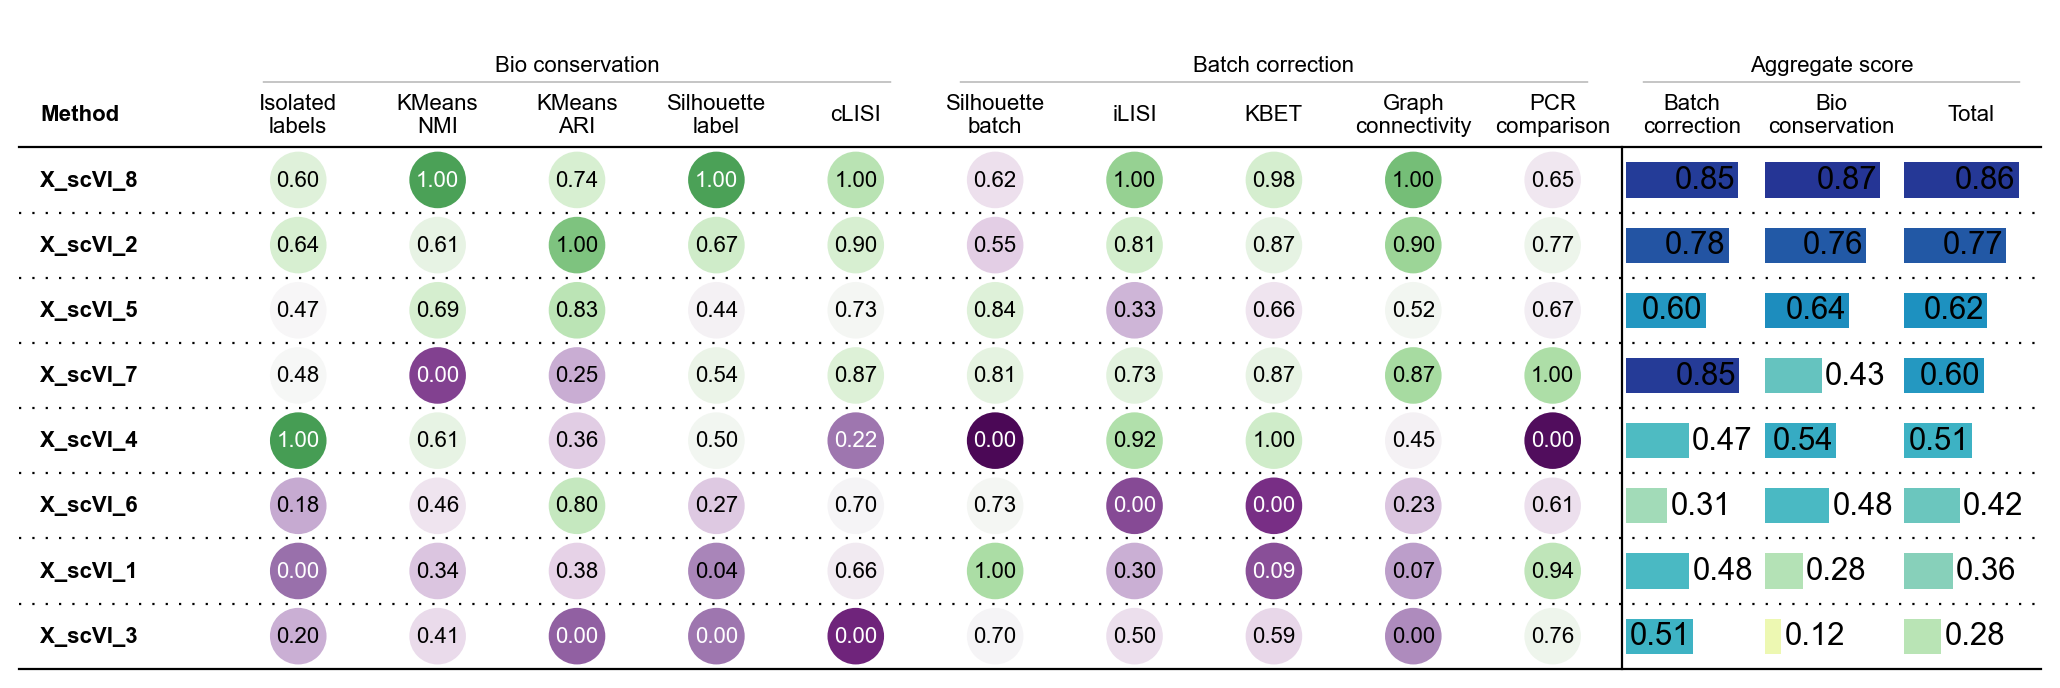

In [96]:
# Benchmark vis

bm.plot_results_table()

In [ ]:
# from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
X_scVI_1             0.523559          0.464472          0.288238   
X_scVI_2             0.534474          0.492339          0.356861   
X_scVI_3             0.524438          0.484389          0.312071   
X_scVI_4             0.536906          0.483577          0.262632   
X_scVI_5             0.533209          0.438284          0.287378   
X_scVI_6             0.527048          0.409925          0.231251   
X_scVI_7             0.532606          0.493494          0.348754   
X_scVI_8              0.53433          0.459336          0.311309   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
X_scVI_1             0.512065          0.976573          0.977945   
X_scVI_2             0.530273          0.990408          0.969066   
X_scVI_3             0.513911           0.97912          0.978806   
X_scVI_4             0.528098          0.962025          0.969824   
X_scVI_5             0.518885          0.979613          0.975012   
X_scVI_6             0.516904           0.98004          0.978895   
X_scVI_7             0.526844          0.981521          0.972739   
X_scVI_8             0.533312          0.992389          0.971819   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
X_scVI_1             0.848253          0.777648           0.879842   
X_scVI_2             0.864161          0.816723           0.956893   
X_scVI_3             0.836031           0.74394           0.874733   
X_scVI_4             0.866321          0.816797            0.89601   
X_scVI_5             0.849916          0.803499           0.921373   
X_scVI_6             0.847234          0.786873           0.888975   
X_scVI_7             0.863254          0.825286           0.956741   
X_scVI_8             0.862812           0.81803           0.984583   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
X_scVI_1             0.968959         0.890529         0.552981   
X_scVI_2              0.96308         0.913985         0.580871   
X_scVI_3             0.970347         0.880772         0.562786   
X_scVI_4             0.945823         0.898955         0.554648   
X_scVI_5             0.957155         0.901391         0.551474   
X_scVI_6             0.967336         0.893863         0.533033   
X_scVI_7             0.956625         0.914929         0.576644   
X_scVI_8             0.963905          0.92023         0.566135   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
X_scVI_1            0.688001  
X_scVI_2            0.714117  
X_scVI_3             0.68998  
X_scVI_4            0.692371  
X_scVI_5            0.691441  
X_scVI_6            0.677365  
X_scVI_7            0.711958  
X_scVI_8            0.707773  
Metric Type  Aggregate score